# Importing Libraries

In [502]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import shap

from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from category_encoders import OneHotEncoder
from sklearn.decomposition import PCA

import xgboost as xgb
import lightgbm as lgb

# Importing Dataset

In [503]:
train_df = pd.read_csv("training_dataset.csv")
val_df = pd.read_csv("validation_set.csv")

In [504]:
def add_engineered_features(df):
    ret = df.copy()

    ret['high_season'] = ret['bulan_kontak_terakhir'].apply(lambda x: 1 if x in ['oct', 'mar', 'sep', 'apr', 'dec'] else 0)
    ret['pernah_dikontak'] = (ret['hari_sejak_kontak_sebelumnya'] == 999).astype(int)

    return ret

In [ ]:
def create_custom_pipeline():
    numerical_features_for_scaling = [
        'suku_bunga_euribor_3bln',
        'indeks_kepercayaan_konsumen',
    ]

    categorical_features = [
        'hasil_kampanye_sebelumnya',
        'pernah_dikontak',
        'jenis_kontak',
        'high_season',
    ]

    features_for_pca = [
        'tingkat_variasi_pekerjaan',
        'indeks_harga_konsumen',
        'jumlah_pekerja',
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num_scale', StandardScaler(), numerical_features_for_scaling),
            ('cat_encode', OneHotEncoder(handle_unknown='ignore'), categorical_features),
            ('pca_features', Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=1))
            ]), features_for_pca)
        ],
        remainder='drop'
    )

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    return pipeline

In [506]:
target_column_name = 'berlangganan_deposito'

X = train_df.drop(columns=[target_column_name])
y = train_df[target_column_name]

models = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

seed_count = 0
score_sum = 0
for seed in range(1, 20, 4):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    for name, model in models.items():
        print(f"\n--- Training and Evaluating with seed: {seed} ---")
        roc_auc_scores = []
        fold = 1
        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            pipeline = create_custom_pipeline()
            
            X_train = add_engineered_features(X_train)
            X_train_transformed = pipeline.fit_transform(X_train)

            X_val = add_engineered_features(X_val)
            X_val_transformed = pipeline.transform(X_val)

            model.fit(X_train_transformed, y_train)
            y_pred_proba = model.predict_proba(X_val_transformed)[:, 1]
            roc_auc = roc_auc_score(y_val, y_pred_proba)
            roc_auc_scores.append(roc_auc)

            print(f"Fold {fold} ROC AUC: {roc_auc:.4f}")
            fold += 1
        print(f"Average ROC AUC for {name}: {sum(roc_auc_scores) / len(roc_auc_scores):.4f}")
        score_sum += sum(roc_auc_scores) / len(roc_auc_scores)

    seed_count += 1

print(f"Final average: {score_sum / seed_count:.4f}")


--- Training and Evaluating with seed: 1 ---
Fold 1 ROC AUC: 0.8006
Fold 2 ROC AUC: 0.8006
Fold 3 ROC AUC: 0.8044
Fold 4 ROC AUC: 0.7729
Fold 5 ROC AUC: 0.7997
Average ROC AUC for Gradient Boosting: 0.7956

--- Training and Evaluating with seed: 5 ---
Fold 1 ROC AUC: 0.7965
Fold 2 ROC AUC: 0.7853
Fold 3 ROC AUC: 0.8067
Fold 4 ROC AUC: 0.8004
Fold 5 ROC AUC: 0.7956
Average ROC AUC for Gradient Boosting: 0.7969

--- Training and Evaluating with seed: 9 ---
Fold 1 ROC AUC: 0.7880
Fold 2 ROC AUC: 0.7902
Fold 3 ROC AUC: 0.7854
Fold 4 ROC AUC: 0.8035
Fold 5 ROC AUC: 0.8222
Average ROC AUC for Gradient Boosting: 0.7978

--- Training and Evaluating with seed: 13 ---
Fold 1 ROC AUC: 0.7838
Fold 2 ROC AUC: 0.7882
Fold 3 ROC AUC: 0.8151
Fold 4 ROC AUC: 0.8139
Fold 5 ROC AUC: 0.7847
Average ROC AUC for Gradient Boosting: 0.7971

--- Training and Evaluating with seed: 17 ---
Fold 1 ROC AUC: 0.8051
Fold 2 ROC AUC: 0.7857
Fold 3 ROC AUC: 0.7909
Fold 4 ROC AUC: 0.7963
Fold 5 ROC AUC: 0.8100
Average R

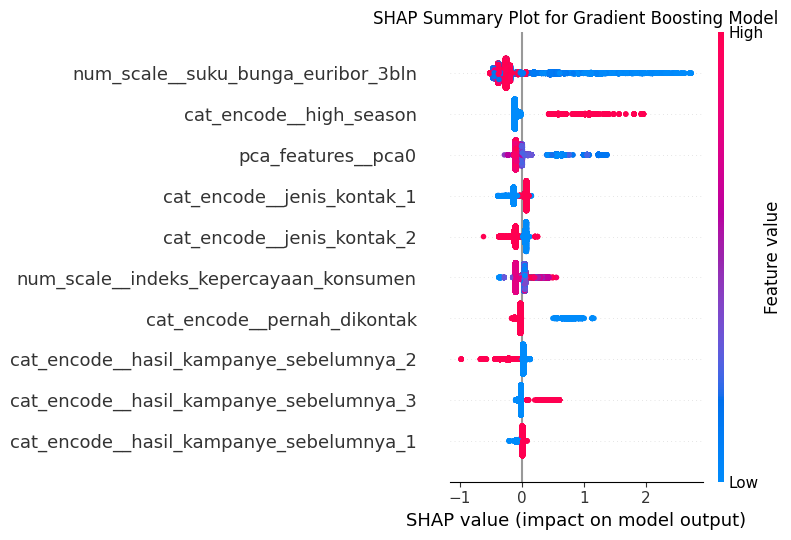

SHAP plot generated.


In [507]:
target_column_name = 'berlangganan_deposito'
X = train_df.drop(columns=[target_column_name])
y = train_df[target_column_name]

single_model_for_shap = GradientBoostingClassifier(random_state=42)

X_full_engineered = add_engineered_features(X.copy())
full_pipeline = create_custom_pipeline()
X_full_transformed = full_pipeline.fit_transform(X_full_engineered)

single_model_for_shap.fit(X_full_transformed, y)

transformed_feature_names = full_pipeline.named_steps['preprocessor'].get_feature_names_out()

X_full_transformed_df = pd.DataFrame(X_full_transformed, columns=transformed_feature_names)

explainer = shap.TreeExplainer(single_model_for_shap)
raw_shap_values = explainer.shap_values(X_full_transformed_df)

if isinstance(raw_shap_values, list):
    shap_values_for_plot = raw_shap_values[1]
else:
    shap_values_for_plot = raw_shap_values

if shap_values_for_plot.ndim == 1:
    shap_values_for_plot = shap_values_for_plot.reshape(-1, 1)


if shap_values_for_plot.shape[1] != X_full_transformed_df.shape[1]:
    print(f"Error: Mismatch in number of features for SHAP plot.")
    print(f"Shape of SHAP values ({shap_values_for_plot.shape[1]}) does not match shape of DataFrame ({X_full_transformed_df.shape[1]}).")
    print("This often happens if feature names are not correctly aligned after complex preprocessing.")
else:
    shap.summary_plot(shap_values_for_plot, X_full_transformed_df, show=False)
    plt.title("SHAP Summary Plot for Gradient Boosting Model")
    plt.tight_layout()
    plt.show()
    print("SHAP plot generated.")